In [1]:
# This notebook runs a test code
import numpy as np
import matplotlib.pyplot as plt
import random 

from scipy import interpolate

# load in custom library
import lunar_processes as pr
from lunar_processes import G, moonM, moonR
# for testing time
import time

In [5]:
def surftime(Temperature):
    # desorption
    Ed = 0.6
    tau_surf = pr.desorption_R21(Temperature, Ed)    
    return tau_surf #np.minimum(tau_surf, tau_sub)


def Model_MonteCarlo(particle, dt, t, local_noon):
    R_bar = pr.R/(pr.m_H2O/1000)
    pMass = pr.mass
    sigma_Sputtering = pr.sput_lifespan_G19
    photo_lifespan =  pr.photo_lifespan_S14

    # results array
    results = np.zeros((8, int(t/dt)+1))*np.nan # (lat, long, tod, temp, exists, total time, hops, dist), 2rd is time
    
    # if exists = True, set 1. Else, set 0
    
    i = 0
    results[0:3, 0] = particle
    results[4, 0] = False
    conda = False
    condb = False
    condc = False
    
    lunar_dt = pr.sec_per_min_M*dt

    # let particle run for 1 lunar rotation
    for i in range(0, int(t/dt), 1):
        st_time = time.time()
        # find initial temperature from location
        results[3, i], n = pr.DivinerT(results[0, i], results[1, i], results[2, i], pr.data)
        
        # define how long it sits for
        tau_surf = surftime(results[3, i])  

        # if it sits for a timestep, test lost, then move to next timestep
        if tau_surf >= lunar_dt:
            conda = pr.loss(sigma_Sputtering, photo_lifespan, lunar_dt, results[2, i])
            if conda == True:
                #print('Particle is lost from sitting')
                results[4, i] = conda
                break
            else:
                #print('Particle is not lost from sitting')
                results[0:3, i+1] = results[0:3, i]
                results[4, i+1] = conda
                results[5, i] = 0
                results[6, i] = 0
                results[7, i] = 0

        else: 
            #print('Particle begins jump')
            tof_tot = 0
            tot_time = 0
            tot_dist = 0
            hops = 0
            while tot_time < lunar_dt:
                #print(tot_time, lunar_dt)
                # while the time of jumping is less than a timestep
                conda = pr.loss(sigma_Sputtering, photo_lifespan, tau_surf, results[2, i])
                if conda == True:
                    #print('Particle is lost during sitting, following a jump')
                    # if lost to loss mechanism, exit loop. 
                    results[4, i+1] = conda
                    break
                else:
                    # let it bounce
                    direction, launch = pr.random_vals() 
                    results[0:3, i+1], f_tof, distm, condc = pr.ballistic(results[3, i], results[0, i], results[1, i], results[2, i], direction, launch, pMass, pr.vel_dist)
                    #print(results[0:3, i+1], f_tof, distm, condc)
                    if condc == True:
                        #print('Particle is lost to jeans loss')
                        results[4, i+1] = condc
                        break
                    else:
                        condb = pr.loss(sigma_Sputtering, photo_lifespan, f_tof, results[2, i])

                        hops += 1
                        tof_tot += f_tof
                        tot_dist += distm

                        # is it detroyed in the jump?
                        if condb == True:
                            #print('Particle is lost in jump')
                            results[4, i+1] = condb
                            break
                        else:
                            results[4, i+1] = condb
                            results[3, i+1], n = pr.DivinerT(results[0, i+1], results[1, i+1], results[2, i+1], pr.data)
                            tau_surf = surftime(results[3, i+1])

                            # advance total time. 
                            tot_time += (f_tof + tau_surf)
                            
            results[5, i] = tof_tot
            results[6, i] = hops
            results[7, i] = tot_dist 

        en = time.time()

        if conda == True or condb == True or condc == True:
            #print('Particle is lost from the simulation')
            conda = False
            condb = False
            condc = False
            break
        else:
            #print("Moon rotates: ", 360/(24/dt))
            local_noon += (360/(24/dt)) # degrees
            results[2, i+1] = (12 + (np.rad2deg(results[1, i+1])+local_noon)*(24/360))%24 
    return results[:, :-1]

In [35]:
# Establish run parameters
# Initial longitude of noon
local_noon = 0

# Run time in lunar hours
t = 24

# Size of time step in lunar hours
dt = 0.25 

# Number of particles
n = 100

# establish particles
particles = np.zeros((n, 3)) # latitude, longitude,  tod
particles[:, 0] = np.deg2rad(random.choices(range(-90, 90), k=n)) # latitude in degrees
particles[:, 1] = np.deg2rad(random.choices(range(0, 360), k=n)) # longitude in degrees
particles[:, 2] = (12+(((np.rad2deg(particles[:, 1]-local_noon))*24)/360))%24 # tod, based on where local noon is

# run
results = np.zeros((n, 8, int(t/dt)))

# start timer
st = time.time()

# Run model for n particles, 1 lunar day time step 1/2 hr (lunar)
for i in range(0, n, 1):
    results[i, :, :] = Model_MonteCarlo(particles[i, :], dt, t, local_noon)
    if i % 10 ==0:
            print('particle', i)

print('Total simulation time: %2.1f'%(time.time() - st))

print('Lunar time step: %3.2e'%(pr.sec_per_hour_M*dt))

particle 0
particle 10
particle 20
lacking tod data, expanding search
particle 30
particle 40
lacking tod data, expanding search
particle 50
particle 60
particle 70
lacking tod data, expanding search
particle 80
lacking tod data, expanding search
particle 90
lacking tod data, expanding search
Total simulation time: 8144.6
Lunar time step: 2.66e+04


[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[ True  True  True ... False False False]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


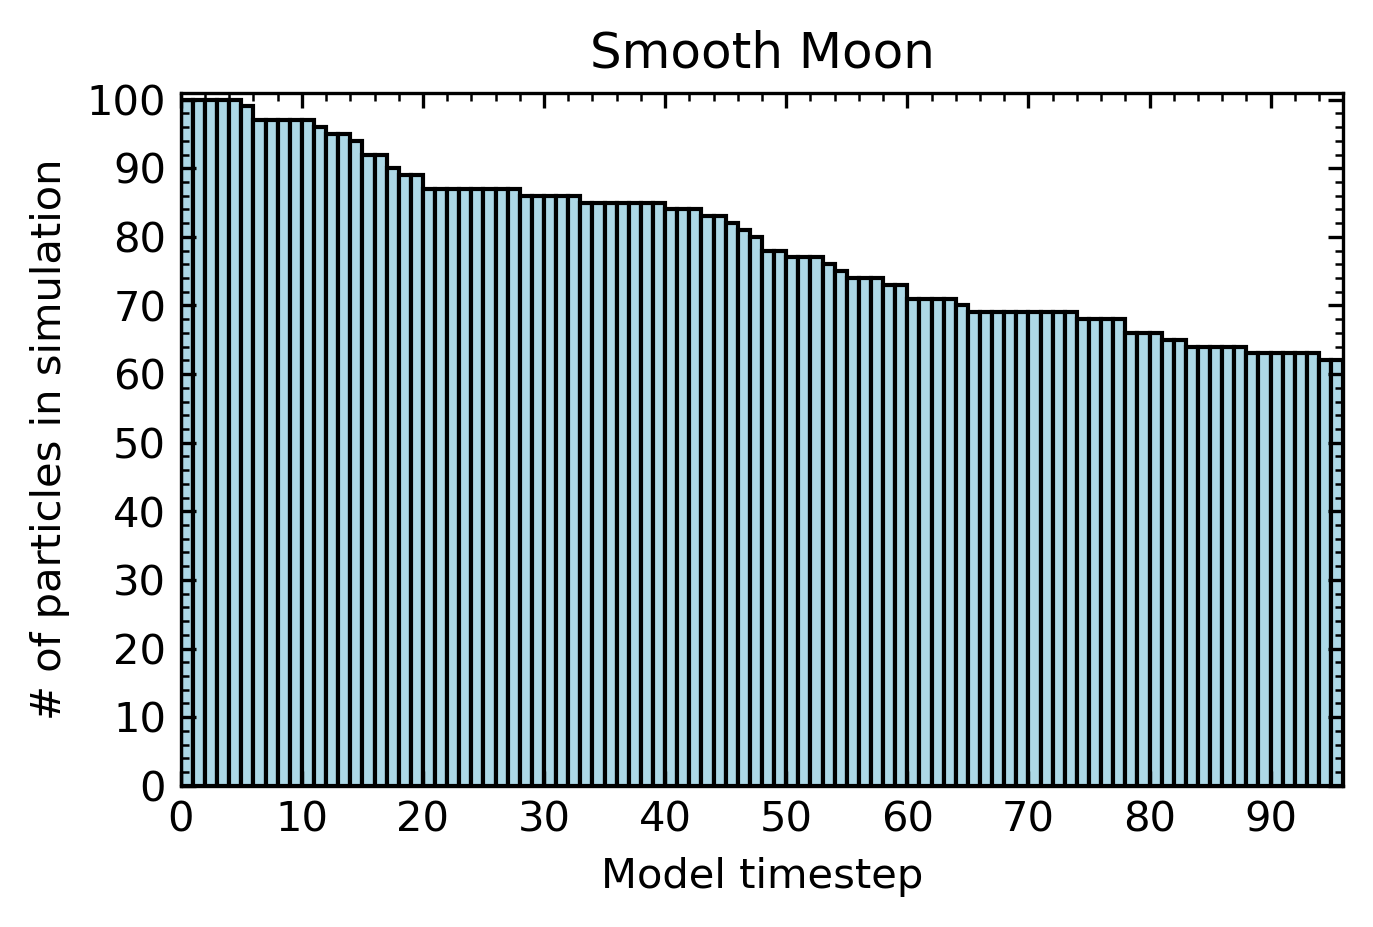

In [94]:
# survival percent through time
#mask = results[:, 4, :] == 1
smoothmoon = results
#smoothmoon[mask]
masks = ~(smoothmoon[:, 4, :] ==1)
print(smoothmoon[:, 4, :], masks)
S, edgess = np.histogram(smoothmoon[:, 4, :][masks], bins=2, range=(-1, 1))
edges = np.array(edgess)[1:]

plt.figure(figsize=(5, 3), dpi= 300)
timestep = 96
for t in range(timestep):
    #masks = ~np.isnan(smoothmoon[:, 4, t])
    masks = ~(smoothmoon[:, 4, t] ==1)
    S, edges = np.histogram(smoothmoon[:, 4, t][masks], bins=2, range=(-1, 1))
    plt.bar(t+0.5, S[1], width=1, edgecolor='k', facecolor='lightblue')

plt.yticks(np.arange(0, 101, 10))
plt.yticks(np.arange(0, 101, 2), minor=True)
plt.ylim((0, 101))

plt.xticks(np.arange(0, 96, 10))
plt.xticks(np.arange(0, 96, 2), minor=True)
plt.xlim((0, 96))
plt.xlabel('Model timestep')
plt.ylabel('# of particles in simulation')
plt.title('Smooth Moon')

plt.tick_params(which='both', labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                     bottom=True, top=True, left=True, right=True, direction='in')
plt.show()

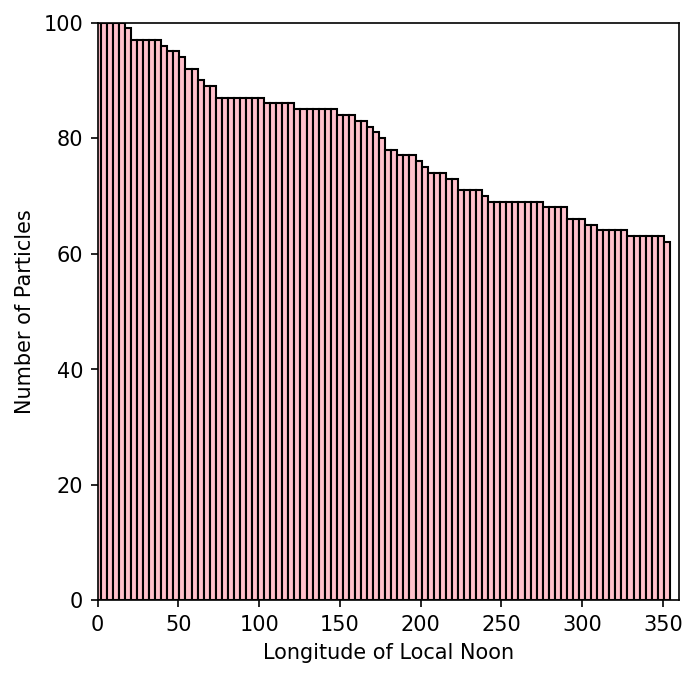

In [52]:
# How many particles
local_noons = np.arange(0, 360, 7.5/2)
t = 24
plt.figure(figsize=(5, 5), dpi=150)
for i in range(int(t/dt)-1):
    if i > 0:
        mask = np.isnan(results[:, 4, i])
        adj = results[:, 4, i]
        adj[mask] = 1
        hists = np.nansum(adj)
    else:
        hists = np.nansum(results[:, 4, i])
    plt.bar(local_noons[i], n-hists, width=7.5/2, align='center', edgecolor='k', color='pink')
plt.ylabel('Number of Particles')
plt.xlabel('Longitude of Local Noon')
plt.ylim((0, n))
plt.xlim((0, 360))
plt.show()

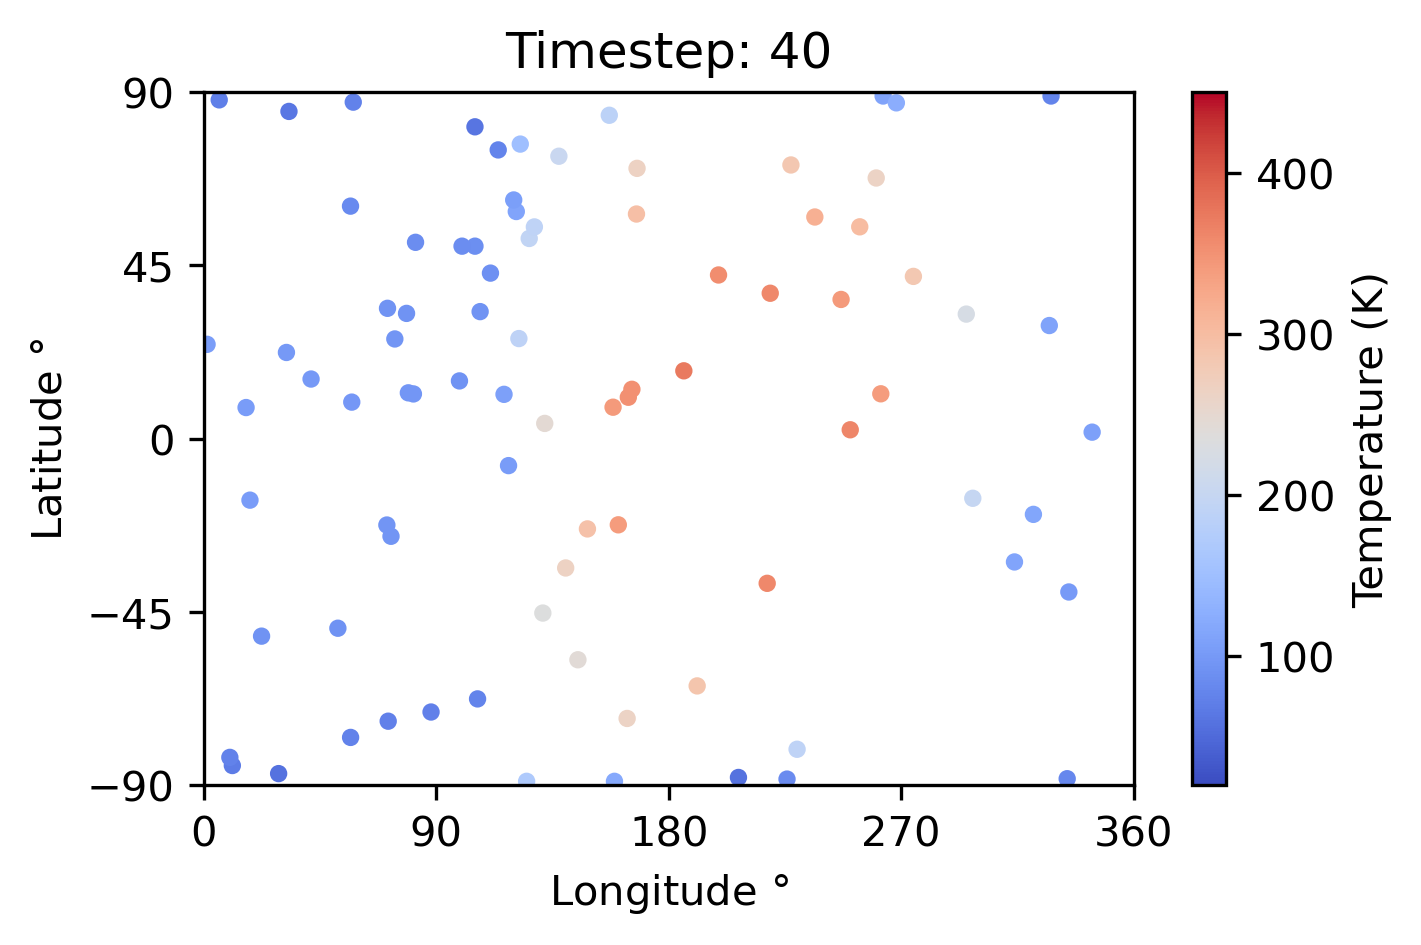

In [42]:
t = 40

plt.figure(figsize=(5, 3), dpi=300)
plt.scatter(np.rad2deg(results[:, 1, t]), np.rad2deg(results[:, 0, t]), c=results[:, 3, t], cmap='coolwarm', s=10, vmin=20, vmax=450)
plt.colorbar(label='Temperature (K)')
plt.ylabel('Latitude $\degree$')
plt.xlabel('Longitude $\degree$')
plt.ylim((-90, 90))
plt.xlim((0, 360))
plt.yticks([-90, -45, 0, 45, 90])
plt.xticks([0, 90, 180, 270, 360])
plt.title('Timestep: %2.0f'%t)
plt.show()

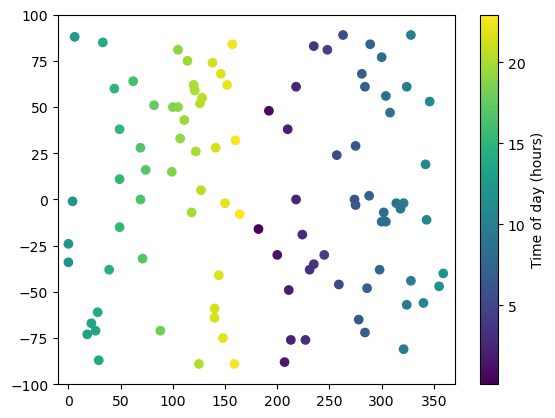

In [41]:
# check distribution
plt.scatter(np.rad2deg(particles[:, 1]), np.rad2deg(particles[:, 0]), c=particles[:, 2])
plt.ylim((-100, 100))
plt.xlim((-10, 370))
plt.colorbar(label='Time of day (hours)')
plt.show()

In [76]:
tt = 80
mask = results[:, 4, tt] == 1
print(np.shape(mask))
print(np.size(results[~mask, 4, tt]))
print(results[:, 5, tt])

(100,)
66
[          nan  676.24476732  554.07151635           nan    0.
    0.            0.            0.          478.39127172           nan
    0.                   nan    0.                   nan           nan
 1025.43864149  616.75444671           nan    0.                   nan
           nan    0.            0.                   nan  570.03203466
           nan    0.                   nan    0.                   nan
    0.            0.                   nan 1383.82022914           nan
    0.            0.                   nan    0.            0.
           nan    0.            0.            0.                   nan
    0.            0.         1049.74332003  577.4358132            nan
  550.48479909  710.0193278     0.            0.                   nan
    0.            0.            0.            0.          465.07719988
    0.                   nan    0.            0.            0.
           nan           nan    0.                   nan           nan
    0.              